In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
import random
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy.random import seed
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import cv2
from tensorflow.random import set_seed
import warnings
%matplotlib inline

In [3]:
pd.options.display.max_colwidth = 100
seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(42)
warnings.filterwarnings('ignore')

In [4]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [5]:
main_path = "/content/drive/MyDrive/chest_xray"

train_path = os.path.join(main_path,"train")

test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")

train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")

test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [6]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [7]:
df_train

,class,image
0,Normal,/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL-3342765-0001.jpeg
1,Normal,/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL-3269314-0001.jpeg
2,Normal,/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL-3342765-0002.jpeg
3,Normal,/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL-3250852-0001.jpeg
4,Normal,/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL-3526928-0001.jpeg
...,...,...
5227,Pneumonia,/content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-4057077-0001.jpeg
5228,Pneumonia,/content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-3955228-0001.jpeg
5229,Pneumonia,/content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-4371619-0002.jpeg
5230,Pneumonia,/content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-387616-0001.jpeg


In [8]:
df_test

,class,image
0,Normal,/content/drive/MyDrive/chest_xray/test/NORMAL/NORMAL-1160949-0001.jpeg
1,Normal,/content/drive/MyDrive/chest_xray/test/NORMAL/NORMAL-115218-0001.jpeg
2,Normal,/content/drive/MyDrive/chest_xray/test/NORMAL/NORMAL-11419-0001.jpeg
3,Normal,/content/drive/MyDrive/chest_xray/test/NORMAL/NORMAL-1049278-0001.jpeg
4,Normal,/content/drive/MyDrive/chest_xray/test/NORMAL/NORMAL-1212407-0001.jpeg
...,...,...
656,Pneumonia,/content/drive/MyDrive/chest_xray/test/PNEUMONIA/VIRUS-9476607-0001.jpeg
657,Pneumonia,/content/drive/MyDrive/chest_xray/test/PNEUMONIA/VIRUS-9342284-0001.jpeg
658,Pneumonia,/content/drive/MyDrive/chest_xray/test/PNEUMONIA/VIRUS-8377377-0001.jpeg
659,Pneumonia,/content/drive/MyDrive/chest_xray/test/PNEUMONIA/VIRUS-9564688-0002.jpeg


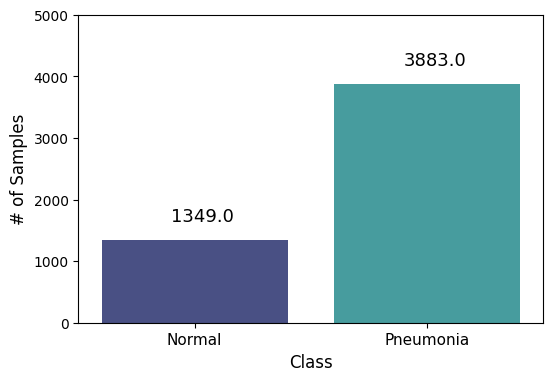

In [9]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)

plt.show()

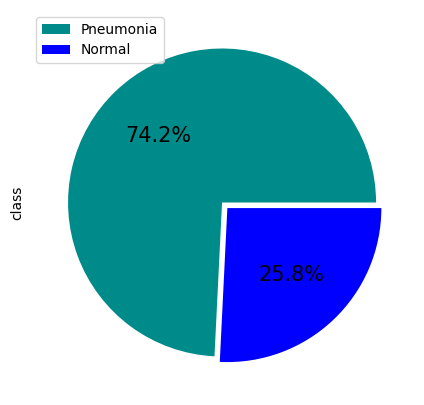

In [10]:
plt.figure(figsize=(7,5))

df_train['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

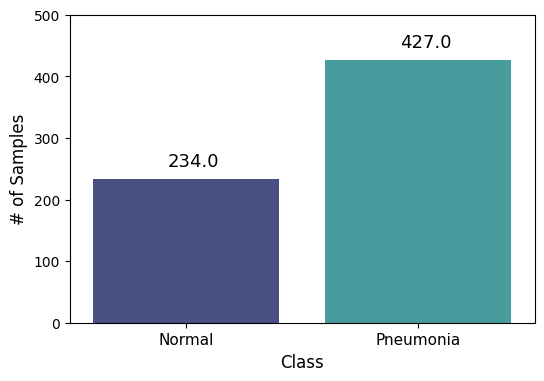

In [11]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_test, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,500)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+20), fontsize = 13)

plt.show()

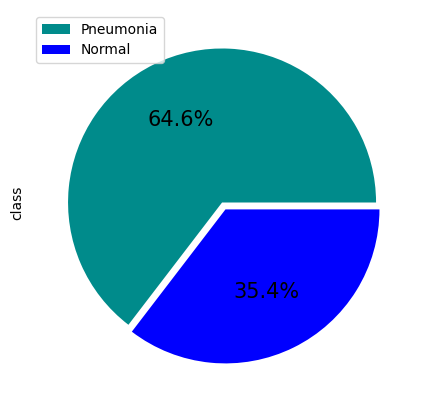

In [12]:
plt.figure(figsize=(7,5))

df_test['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

Train Set - Normal


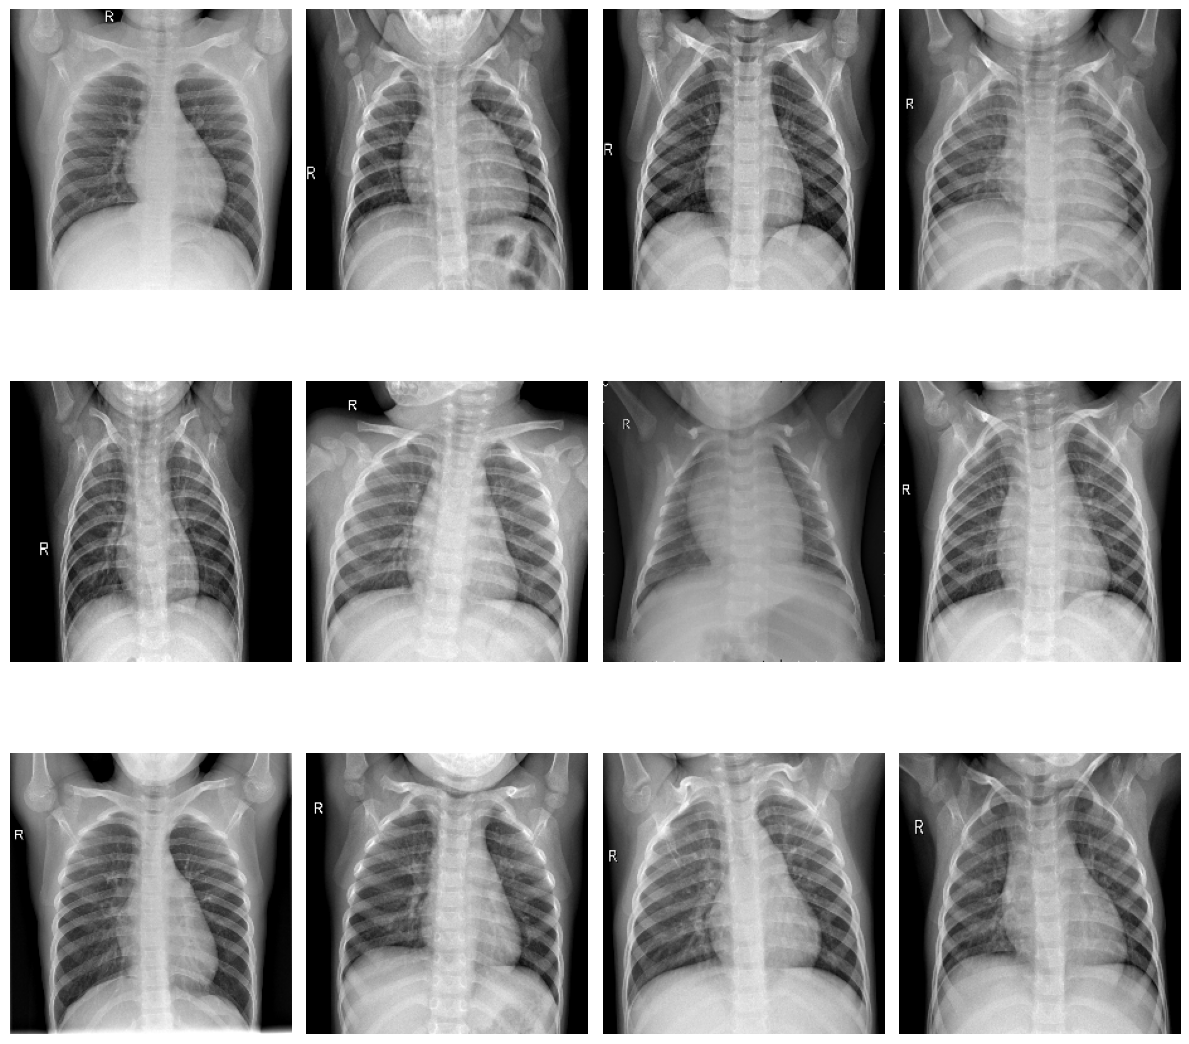

In [13]:
print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

Train Set - Pneumonia


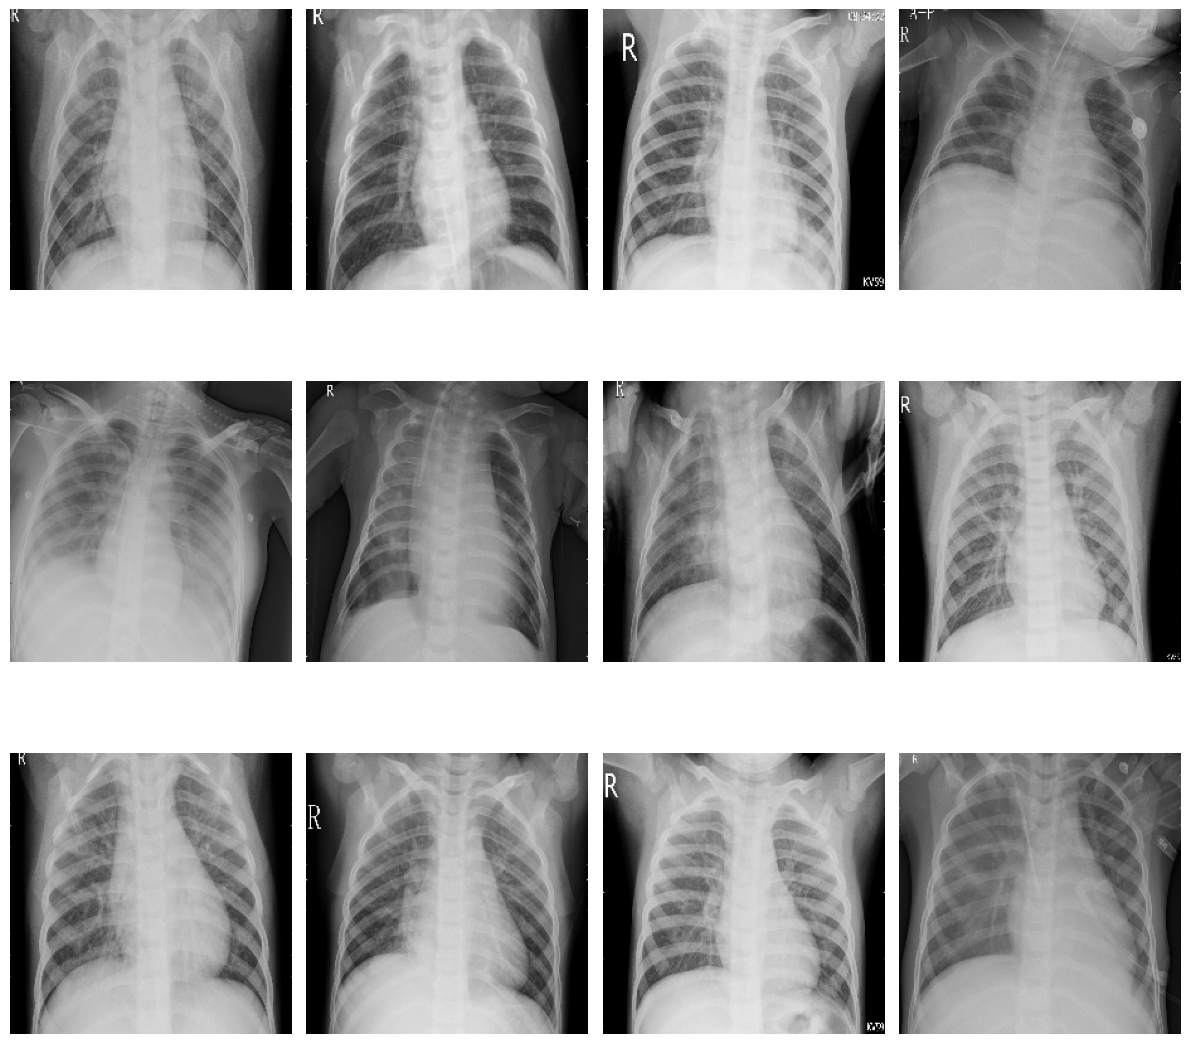

In [14]:
print('Train Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Normal


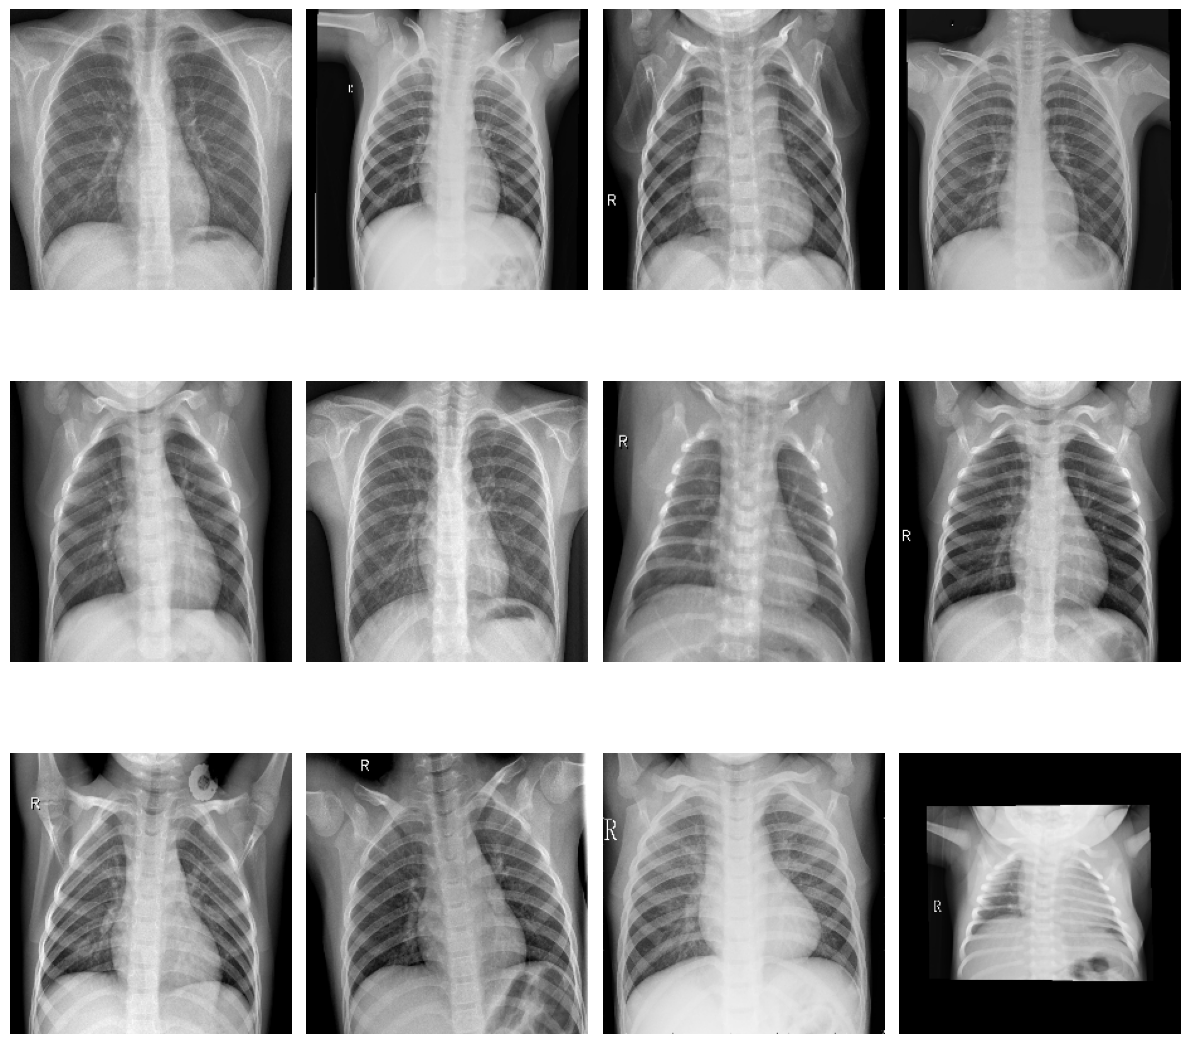

In [15]:
print('Test Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Pneumonia


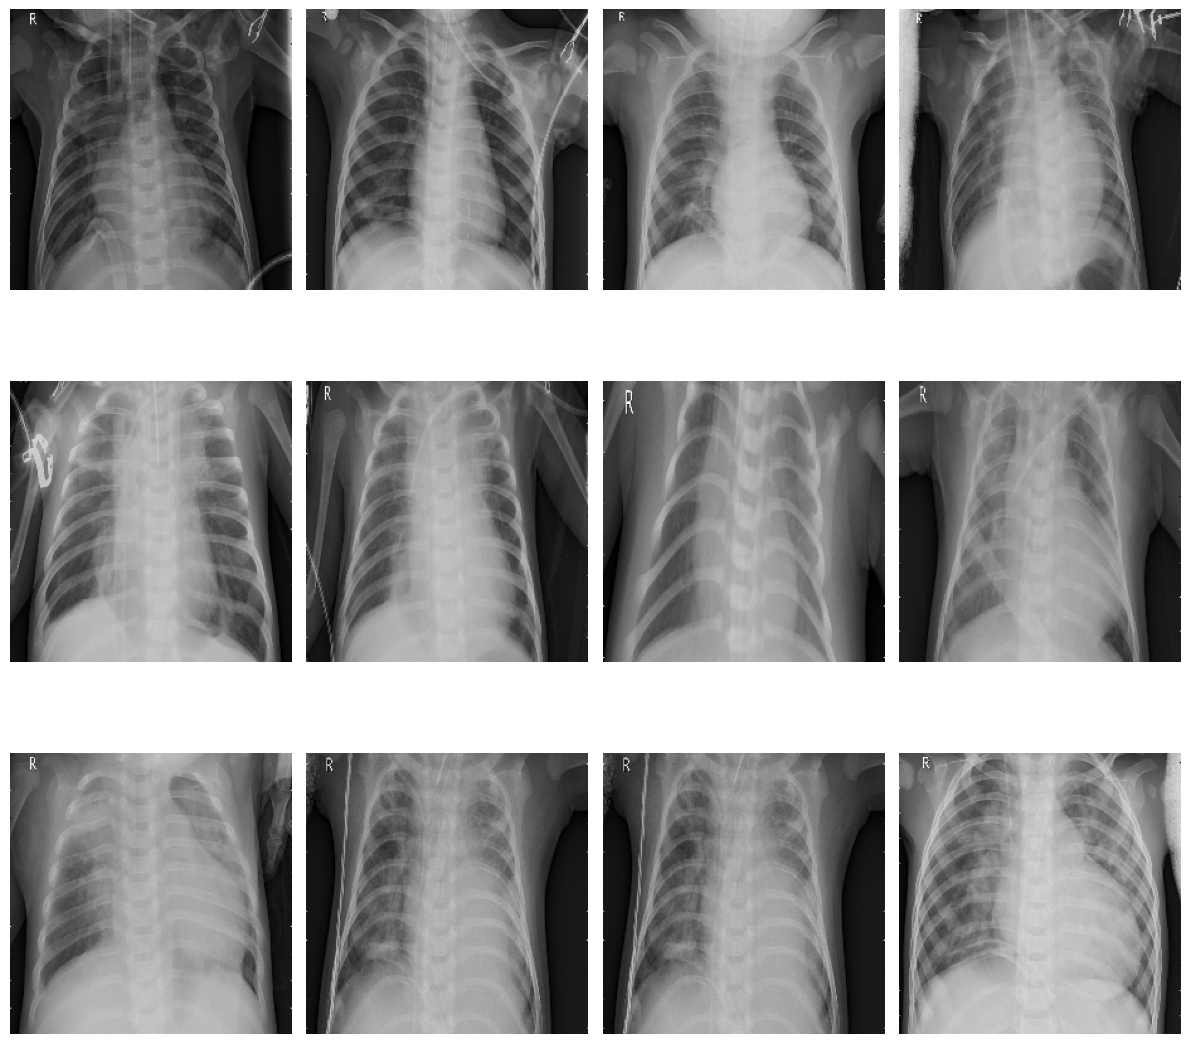

In [16]:
print('Test Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

In [17]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [18]:
train_df

,class,image
3566,Pneumonia,/content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-4799529-0001.jpeg
2866,Pneumonia,/content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-9530903-0004.jpeg
2681,Pneumonia,/content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-864208-0002.jpeg
1199,Normal,/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL-2386123-0001.jpeg
4619,Pneumonia,/content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-1797366-0001.jpeg
...,...,...
3476,Pneumonia,/content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-4932029-0003.jpeg
678,Normal,/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL-7824011-0001.jpeg
1560,Pneumonia,/content/drive/MyDrive/chest_xray/train/PNEUMONIA/VIRUS-52163-0003.jpeg
2769,Pneumonia,/content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-9424776-0001.jpeg


In [19]:
val_df

,class,image
2945,Pneumonia,/content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-9835318-0001.jpeg
4878,Pneumonia,/content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-3362849-0001.jpeg
3177,Pneumonia,/content/drive/MyDrive/chest_xray/train/PNEUMONIA/VIRUS-2427242-0005.jpeg
972,Normal,/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL-9756687-0001.jpeg
3059,Pneumonia,/content/drive/MyDrive/chest_xray/train/PNEUMONIA/VIRUS-1591633-0002.jpeg
...,...,...
253,Normal,/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL-5075834-0001.jpeg
4315,Pneumonia,/content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-7847892-0004.jpeg
687,Normal,/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL-7953615-0001.jpeg
3417,Pneumonia,/content/drive/MyDrive/chest_xray/train/PNEUMONIA/BACTERIA-4352107-0001.jpeg


In [20]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,

                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,

                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,

                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,

                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 661 validated image filenames belonging to 2 classes.
